# Introduction
In this notebook I build on the work of the author changing his original code as well as adding some additional examples of how SVM can be utilised.<br>
Source: https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb<br>
The original text by the author is written in gray to improve readability<br>
Support: used chatgpt and github copilot

# Change Log
Summary of the changes made:
<ol>
    <li>All the comments added into the code</li>
    <li>Added a section for testing out lienear kernel SVM</li>
    <li>Added a section for testing out RBF kernel SVM using the make circle dataset</li>
    <li>Added a section for testing out RBF kernel SVM using the make moons dataset</li>
    <li>Added a section where I created a colour classification model</li>
</ol>

# <span style="color: grey;">In Depth: Support Vector Machines

<span style="color: grey;">
Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this chapter, we will explore the intuition behind SVMs and their use in classification problems.<br>

We begin with the standard imports:
</span>

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid') # Changed the style since original wasn't working
from scipy import stats

## <span style="color: grey;">Motivating Support Vector Machines

<span style="color: grey;">
As part of our discussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned about a simple kind of model that describes the distribution of each underlying class, and experimented with using it to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*. That is, rather than modeling each class, we will simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.<br>

As an example of this, consider the simple case of a classification task in which the two classes of points are well separated (see the following figure):
</span>

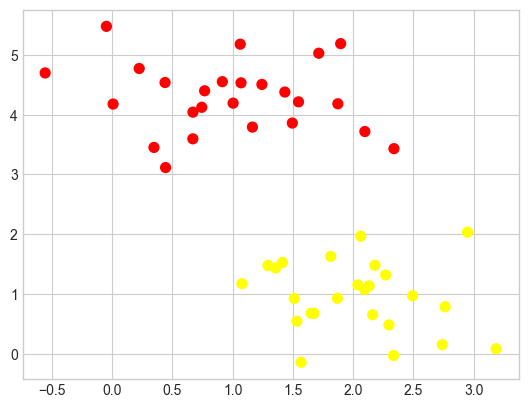

In [3]:
from sklearn.datasets import make_blobs
# The make_blobs function is used to generate a dataset of points that are clustered together
# The parameters passed into it mean the following:
# 300 = number of points
# 2 = number of features
# centers=3 = number of clusters
# random_state=2 = random seed
# cluster_std=2 = standard deviation of the clusters
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

<span style="color: grey;">
A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two-dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!<br>

We can draw some of them as follows; the following figure shows the result:
</span>

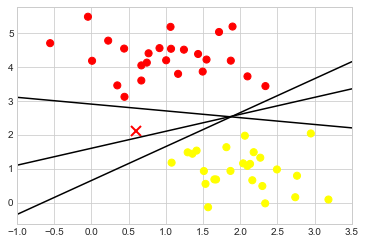

In [ ]:
xfit = np.linspace(-1, 3.5) # Creates an array of evenly spaced values from -1 to 3.5
# Creates a scatter plot and an x at the point (0.6, 2.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

# Creates 3 lines that divide the data
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

# Sets the limits for the x-axis
plt.xlim(-1, 3.5);

<span style="color: grey;">
These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not good enough, and we need to think a bit more deeply.
</span>

## <span style="color: grey;">Support Vector Machines: Maximizing the Margin
<span style="color: grey;">
Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.<br>
Here is an example of how this might look (see the following figure):
</span>

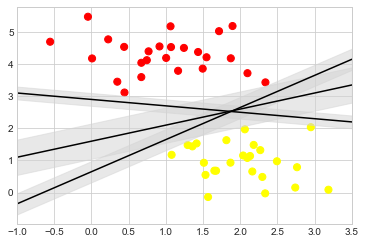

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    # Adds a light gray area around the lines to the chart from above
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='lightgray', alpha=0.5)

plt.xlim(-1, 3.5);

<span style="color: grey;">The line that maximizes this margin is the one we will choose as the optimal model.</span>

### <span style="color: grey;">Fitting a Support Vector Machine
<span style="color: grey;">
Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier (`SVC`) to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily):
</span>

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
# The SVC class is used to fit the model to the data
# kerlne='linear' = tries to find a straight - line to divide the data
# C=1E10 = regularization parameter
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

<span style="color: grey;">
To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us (see the following figure):
</span>

In [9]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca() # If ax wasnt provided the current axes will be used
    # Gets the limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    # Creates evenly spaced values from the x and y limits
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    # Creates a grid from the x and y values
    Y, X = np.meshgrid(y, x)
    # ravel() - converts the 2D arrays into 1D arrays for X and Y
    # np.vstack() - stacks the 1D arrays on top of each other, 
    # so it creates a 2D array for xy pairs
    # The .T flips the array so that the x and y values are in the correct format
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    # Decision function is used to evaluate the model, by returning the distance of each point
    # from the decision boundary
    # reshape() - converts the 1D array into a 2D array
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    # These margins show how certain a point is to be in a certain class
    # If its between the boundary of the margins, then the model is uncertain about the point
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    # Highlights the support vectors with a black circle
    # Support vectors are the points that are used to define the decision boundary
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    # Simplt sets the limits for the x and y axis
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

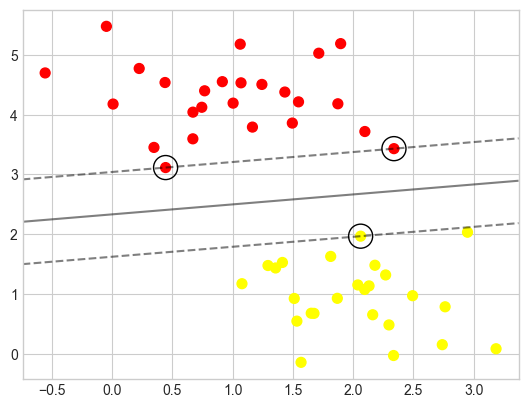

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

<span style="color: grey;">This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are circled in the following figure.
These points are the pivotal elements of this fit; they are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identities of these points are stored in the `support_vectors_` attribute of the classifier:
</span>

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

<span style="color: grey;">A key to this classifier's success is that for the fit, only the positions of the support vectors matter; any points further from the margin that are on the correct side do not modify the fit.
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

<span style="color: grey;">
We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset (see the following figure):

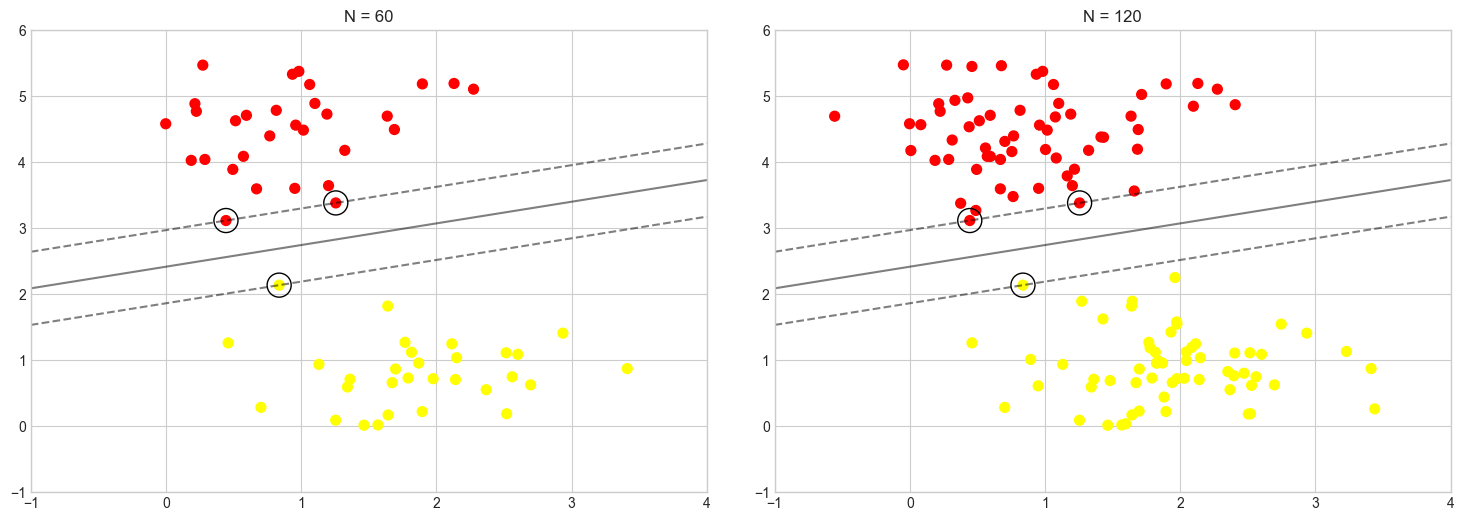

In [10]:
def plot_svm(N=10, ax=None):
    # Creates data points
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    # Fits the model to the data
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    # Plots the data points and the decision boundary
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

# Creates 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

<span style="color: grey;">In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors in the left panel are the same as the support vectors in the right panel.<br>
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.
</span>

<span style="color: grey;">If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

interactive(children=(IntSlider(value=10, description='N', max=200, min=10), Output()), _dom_classes=('widget-…

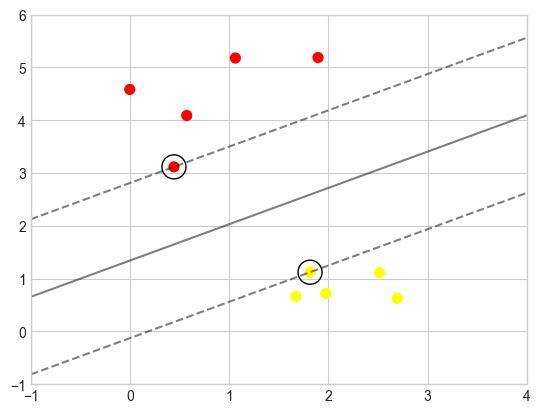

In [12]:
# This is just an interactive widget that allows you to change the number of points
# and see that it doesnt change the decision boundary
from ipywidgets import interact, fixed
interact(plot_svm, N=(10, 200), ax=fixed(None));

### <span style="color: grey;">Beyond Linear Boundaries: Kernel SVM
<span style="color: grey;">
Where SVM can become quite powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).
There we projected our data into a higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.
<br>
<span style="color: grey;">
In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable (see the following figure):

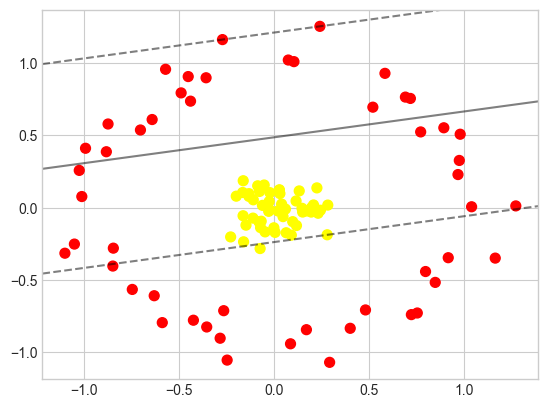

In [16]:
# This creates a dataset that is not linearly separable, 
# and shows how that looks like a graph
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

<span style="color: grey;">
It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.<br>
For example, one simple projection we could use would be to compute a *radial basis function* (RBF) centered on the middle clump:
</span>

In [ ]:
# exp() - calculates the exponential of all the values in the array using the formula e^x
# X ** 2 - squares each value in the array
# sum(1) - sums the values in the array
# r contains the values for the new feature that was created
r = np.exp(-(X ** 2).sum(1))

<span style="color: grey;">We can visualize this extra data dimension using a three-dimensional plot, as seen in the following figure:

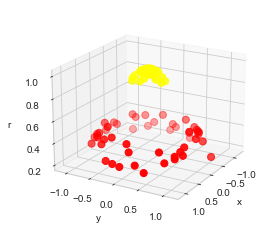

In [ ]:
# The new 3D array that contains the original data and the new feature
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

<span style="color: grey;">
We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

In this case we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection.
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF kernel, using the `kernel` model hyperparameter:
</span>

In [ ]:
# Here the kernel is changed to one that uses Radial Basis Function
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

<span style="color: grey;">Let's use our previously defined function to visualize the fit and identify the support vectors (see the following figure):

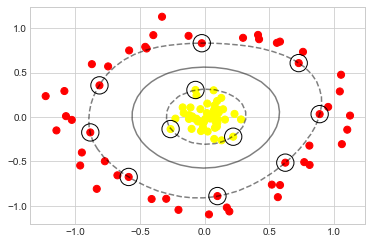

In [ ]:
# The new kernel is used to create a new chart showing how the model partitions the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
# The below scatter graph is useless since the support 
# vectors are already highlighted using the plot_svc_decision_function()
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

<span style="color: grey;">Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### <span style="color: grey;">Tuning the SVM: Softening Margins
<span style="color: grey;">
Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this (see the following figure):

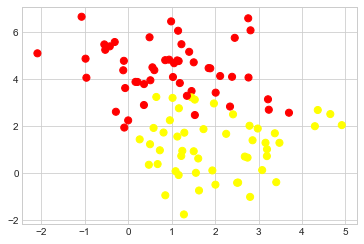

In [ ]:
# New chart is created with a different dataset
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
# The below scatter graph is useless since the support 
# vectors are already highlighted using the plot_svc_decision_function()
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

<span style="color: grey;">
To handle this case, the SVM implementation has a bit of a fudge factor that "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as `C`.
For a very large `C`, the margin is hard, and points cannot lie in it.
For a smaller `C`, the margin is softer and can grow to encompass some points.<br>

The plot shown in the following figure gives a visual picture of how a changing `C` affects the final fit via the softening of the margin:
</span>

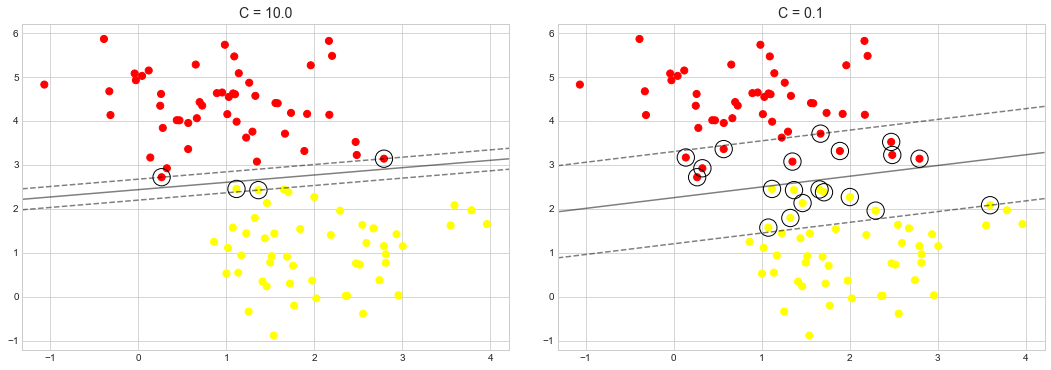

In [ ]:
# Below shows a more messy dataset, 
# and how the model can be adjusted to fit the data using the C parameter to 
# allow for misclassification
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

<span style="color: grey;">The optimal value of `C` will depend on your dataset, and you should tune this parameter using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).

### Trying out he models

Below I take the code written above and adjust it to get a better understanding of it.

#### Linear kernel

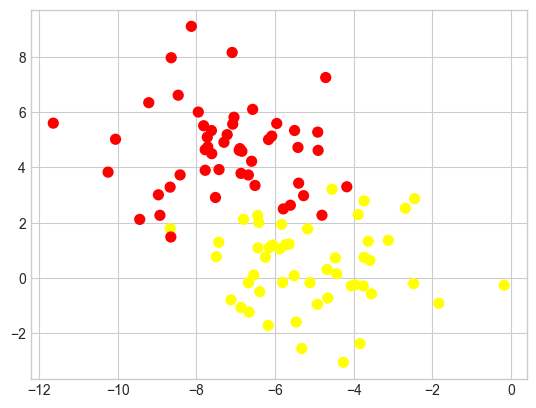

In [30]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=12, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [35]:
from sklearn.svm import SVC 
model = SVC(kernel='linear', C=1E4) # I decreased the C to allow for more misclassifications 
model.fit(X, y)

SVC(C=10000.0, kernel='linear')

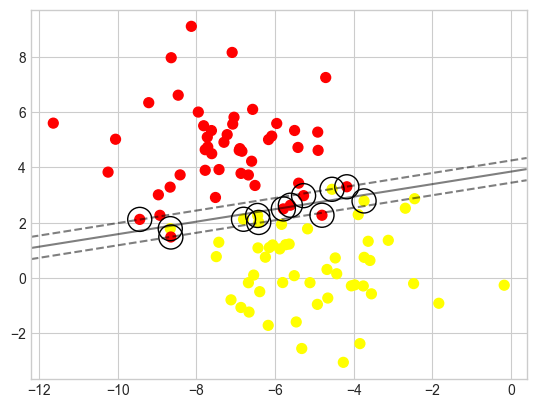

In [36]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

#### RBF kernel - Make Circles Dataset

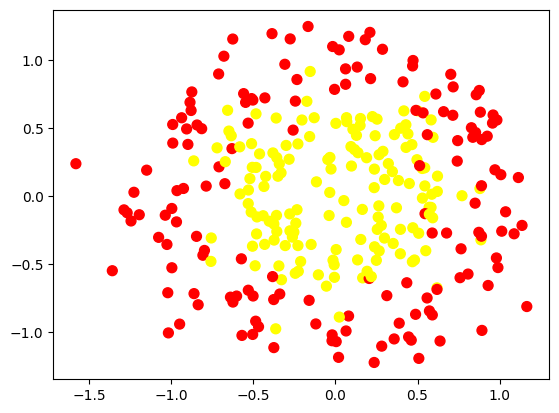

In [62]:
from sklearn.datasets import make_circles
X, y = make_circles(300, factor=.5, noise=.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

As you can see above I made the seperation between the different sections less obvious as well I increased the noise in the data.

In [46]:
r = np.exp(-(X ** 2).sum(1))

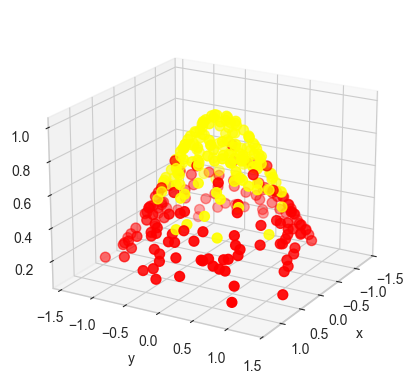

In [47]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

Above shows how the noise affected the RBF function

In [17]:
from sklearn.svm import SVC 
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

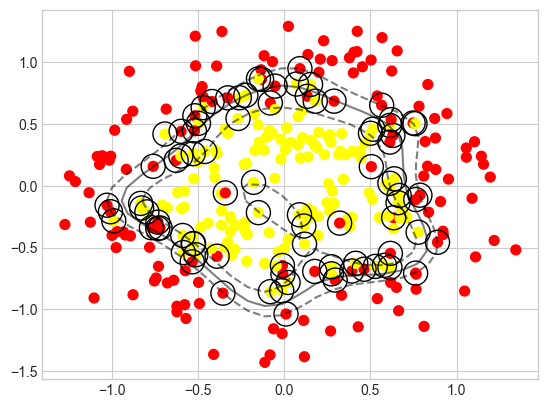

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)


Above the hyperplane is overfitting the data so I decide to lower the C value below.

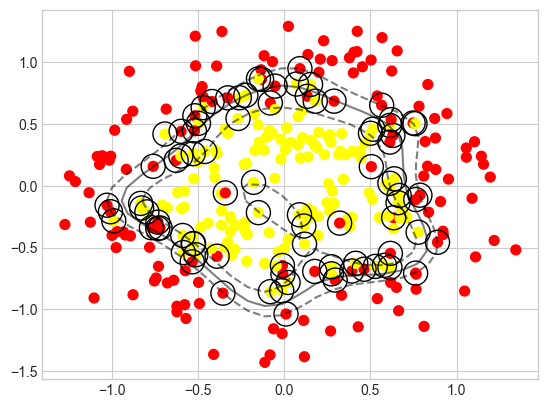

In [15]:
from sklearn.svm import SVC 
clf = SVC(kernel='rbf', C=1E3)
clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)

As you can see the hyperplane looks like it fits the data better now.

#### RBF kernel - Make Moons Dataset

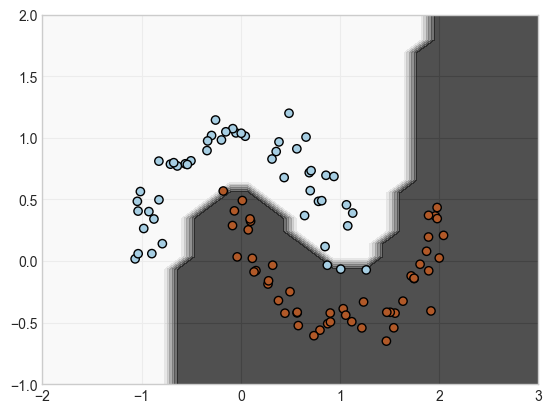

In [ ]:
from sklearn.datasets import make_moons

# Data is generated
X, y = make_moons(n_samples=100, noise=0.1)

# Model is trained
clf = SVC(kernel='rbf', C=1)
clf.fit(X, y)

# Creates enevenly spaced values within the limits
newx = np.linspace(-1, 2, 30)
newy = np.linspace(-2, 3, 30)

# Creates the grid for the graph
meshY, meshX = np.meshgrid(newx, newy)

# Uses the model to predict the 3rd feature using the RBF function
Z = clf.predict(np.c_[meshX.ravel(), meshY.ravel()])
Z = Z.reshape(meshX.shape)

# Draws the charts
plt.contourf(meshX, meshY, Z, alpha=0.75)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.Paired)

Above you can see the SVMs can seperate data with a curved line

## <span style="color: grey;">Example: Face Recognition
<span style="color: grey;">
As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [18]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


<span style="color: grey;">Let's plot a few of these faces to see what we're working with (see the following figure):

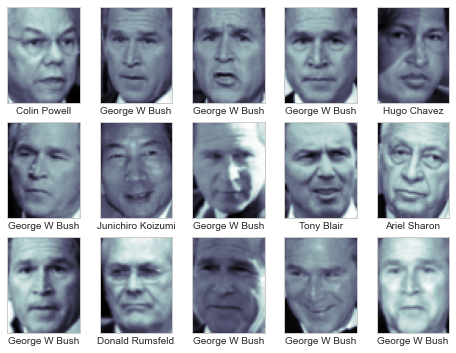

In [19]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

<span style="color: grey;">Each image contains 62 × 47, or around 3,000, pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [20]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

<span style="color: grey;">For the sake of testing our classifier output, we will split the data into a training set and a testing set:

In [21]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

<span style="color: grey;">Finally, we can use grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 19s, sys: 8.56 s, total: 1min 27s
Wall time: 36.2 s
{'svc__C': 10, 'svc__gamma': 0.001}


<span style="color: grey;">The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

<span style="color: grey;">Now with this cross-validated model we can predict the labels for the test data, which the model has not yet seen:

In [23]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

<span style="color: grey;">Let's take a look at a few of the test images along with their predicted values (see the following figure):

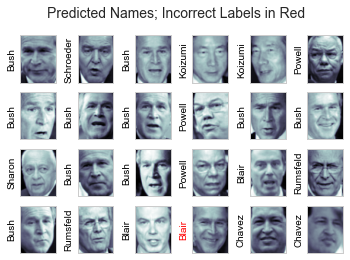

In [24]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

<span style="color: grey;">Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [25]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



<span style="color: grey;">We might also display the confusion matrix between these classes (see the following figure):

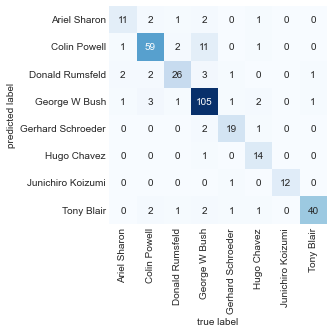

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

<span style="color: grey;">This helps us get a sense of which labels are likely to be confused by the estimator.

<span style="color: grey;">For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pretrained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Example - Color Classification
Source: https://www.kaggle.com/datasets/ayanzadeh93/color-classification/data <br>
The algorithm to help me develop this model comes from: https://www.kaggle.com/code/muhammadadilnaeem/color-classification-using-svm-classifier

In this example I will use SVM to teach a model how to identify the difference between colors.

### Import Dataset
Below I just improt the dataset

In [49]:
file_path = "C:\\Users\\dawid\\Desktop\\ColorClassification"
categories = ["Black", "Blue", "Brown", "Green", "orange", "red", "Violet", "White", "yellow"]
img_size = 1280

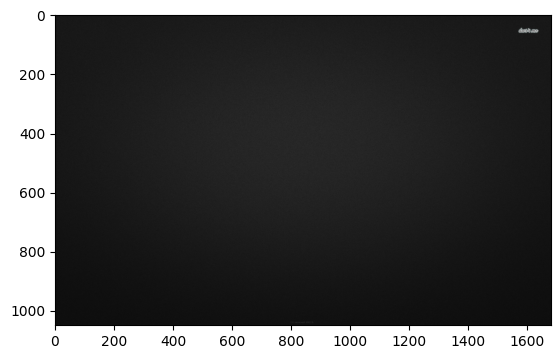

In [29]:
import cv2
import matplotlib.pyplot as plt 

img_array=cv2.imread("C:\\Users\\dawid\\Desktop\\ColorClassification\\Black\\1.jpg")
plt.imshow(img_array)

Above I display the first image in the black colour directory to see if its working.

### Preprocessing data
In this section I extract the data from the directory and prepare it to be processed by the model

In [50]:
import os
training_data=[]
def create_training_data():
    for category in categories:
        path=os.path.join(file_path, category)
        class_num=categories.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(img_size,img_size))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()    

Below I extract he size of the training data

In [31]:
len_img = len(training_data)
print(len_img)

117


Below I extract data from the training array and put it into the format that the model accepts

In [33]:
import numpy as np  

X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(len_img,-1)

### SVM Model

Data split into training and testing sets

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [54]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [ ]:
y_pred = svc.predict(X_test)

### Evaluating the Model

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy of the data is",accuracy_score(y_test,y_pred))

Accuracy on unknown data is 0.43333333333333335


As you can see using rbf is a bad choice for this data most likely due to it being too complex of a model to use on small datasets

In [57]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto', kernel='linear')

In [58]:
y_pred = svc.predict(X_test)

In [59]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y_pred))

Accuracy on unknown data is 0.7666666666666667


As you can see using a linear svm provides, much more accurate results.

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,
                            target_names=categories))

              precision    recall  f1-score   support

       Black       0.75      0.86      0.80         7
        Blue       0.75      0.75      0.75         4
       Brown       0.75      0.86      0.80         7
       Green       0.00      0.00      0.00         1
      orange       0.50      1.00      0.67         1
         red       0.00      0.00      0.00         1
      Violet       0.75      0.60      0.67         5
       White       1.00      1.00      1.00         3
      yellow       1.00      1.00      1.00         1

    accuracy                           0.77        30
   macro avg       0.61      0.67      0.63        30
weighted avg       0.72      0.77      0.74        30



C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dawid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificati

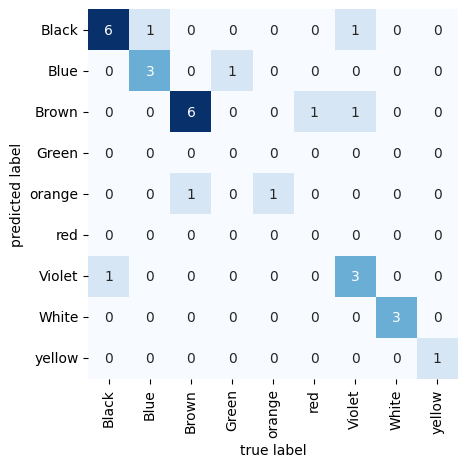

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

As you can see above the model predicted correctly most of the colors.

## Example: Facial recognition of emotions

### Introduction
Use this notebook to help: https://www.kaggle.com/code/mohamedchahed/human-emotion-detection
This dataset was taken from: https://www.kaggle.com/datasets/msambare/fer2013

### Data Import and analysis

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\dawid\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [6]:
trainDir = path + "\\train"
testDir = path + "\\test"

In [11]:
import os
from PIL import Image
import numpy as np
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, emotion in enumerate(os.listdir(folder)):
        emotion_folder = os.path.join(folder, emotion)
        for filename in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize((32, 32))  # Resize to 32x32 (or any suitable size)
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load training and testing data
X_train, y_train = load_images_from_folder(trainDir)
X_test, y_test = load_images_from_folder(testDir)

In [12]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [13]:
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten images
X_test = X_test.reshape(X_test.shape[0], -1)

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train the SVM model with a radial basis function (RBF) kernel
svm_model = SVC(kernel='rbf', gamma='scale', C=1)
svm_model.fit(X_train, y_train)


SVC(C=1)

In [15]:
y_pred = svm_model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4449707439398161
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.22      0.28       958
           1       1.00      0.04      0.07       111
           2       0.38      0.23      0.29      1024
           3       0.49      0.72      0.58      1774
           4       0.40      0.43      0.41      1233
           5       0.36      0.40      0.38      1247
           6       0.65      0.53      0.59       831

    accuracy                           0.44      7178
   macro avg       0.52      0.37      0.37      7178
weighted avg       0.45      0.44      0.43      7178



In [16]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=100)  # Reduce to 100 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the SVM with PCA-reduced data
svm_model.fit(X_train_pca, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_pca)
print(f"Accuracy with PCA: {accuracy_score(y_test, y_pred)}")
print("Classification Report with PCA:")
print(classification_report(y_test, y_pred))

Accuracy with PCA: 0.44037336305377545
Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.38      0.22      0.28       958
           1       1.00      0.01      0.02       111
           2       0.35      0.21      0.26      1024
           3       0.49      0.72      0.58      1774
           4       0.39      0.43      0.41      1233
           5       0.36      0.39      0.38      1247
           6       0.63      0.53      0.58       831

    accuracy                           0.44      7178
   macro avg       0.52      0.36      0.36      7178
weighted avg       0.44      0.44      0.42      7178



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Perform grid search
grid_search = GridSearchCV(SVC(), param_grid, cv=3)
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory = trainDir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

validation_generator = validation_datagen.flow_from_directory(
    directory = testDir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


### Model

### Evaluation

### Conclusion

## <span style="color: grey;">Summary</span>
<span style="color: grey;">
This has been a brief intuitive introduction to the principles behind support vector machines.
These models are a powerful classification method, for a number of reasons:

- Their dependence on relatively few support vectors means that they are compact and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is challenging for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter `C`. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the `probability` parameter of `SVC`), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.
</span>